<a href="https://colab.research.google.com/github/yantiputri/SEMESTER-3/blob/main/Praktikum04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report, RocCurveDisplay, ConfusionMatrixDisplay
)


Menghubungkan dengan Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

#memanggil data lewat gdrive
path = '/content/drive/MyDrive/Praktikum_ml/praktikum04'

Mounted at /content/drive


Load Data

In [3]:
#membaca file csv menggunakan pandas
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/Praktikum_ml/praktikum04/data/stunting_wasting_dataset.csv')
df.head()

,Jenis Kelamin,Umur (bulan),Tinggi Badan (cm),Berat Badan (kg),Stunting,Wasting
0,Laki-laki,19,91.6,13.3,Tall,Risk of Overweight
1,Laki-laki,20,77.7,8.5,Stunted,Underweight
2,Laki-laki,10,79.0,10.3,Normal,Risk of Overweight
3,Perempuan,2,50.3,8.3,Severely Stunted,Risk of Overweight
4,Perempuan,5,56.4,10.9,Severely Stunted,Risk of Overweight


In [4]:
#melihat informasi umum dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Jenis Kelamin      100000 non-null  object 
 1   Umur (bulan)       100000 non-null  int64  
 2   Tinggi Badan (cm)  100000 non-null  float64
 3   Berat Badan (kg)   100000 non-null  float64
 4   Stunting           100000 non-null  object 
 5   Wasting            100000 non-null  object 
dtypes: float64(2), int64(1), object(3)
memory usage: 4.6+ MB


Data Pre-processing


In [5]:
#cek missing value
df.isnull().sum()

,0
Jenis Kelamin,0
Umur (bulan),0
Tinggi Badan (cm),0
Berat Badan (kg),0
Stunting,0
Wasting,0


In [6]:
df.duplicated().sum()

np.int64(7308)

In [7]:
df = df.drop_duplicates()

In [8]:
df.duplicated().sum()

np.int64(0)

In [9]:
#cek nilai unik
df['Stunting'].unique()

array(['Tall', 'Stunted', 'Normal', 'Severely Stunted'], dtype=object)

In [10]:
df['Jenis Kelamin'].unique()

array(['Laki-laki', 'Perempuan'], dtype=object)

In [11]:
# 1. Mapping kolom Stunting -> biner
map_stunt = {'Stunted': 1, 'Severely Stunted': 1, 'Normal': 0, 'Tall': 0}
df['Stunting_bin'] = df['Stunting'].map(map_stunt).astype('Int64')

# 2. Mapping kolom Jenis Kelamin -> biner
#    Laki-Laki = 1, Perempuan = 0
df['JK_bin'] = (df['Jenis Kelamin'] == 'Laki-laki').astype(int)

print("Distribusi Stunting_bin:\n", df['Stunting_bin'].value_counts())
print("\nDistribusi JK_bin:\n", df['JK_bin'].value_counts())

Distribusi Stunting_bin:
 Stunting_bin
0    72320
1    20372
Name: count, dtype: Int64

Distribusi JK_bin:
 JK_bin
1    46353
0    46339
Name: count, dtype: int64


In [12]:
corr_matrix = df.corr(numeric_only=True)
corr_matrix

,Umur (bulan),Tinggi Badan (cm),Berat Badan (kg),Stunting_bin,JK_bin
Umur (bulan),1.000000,0.874162,0.659566,0.037173,0.000636
Tinggi Badan (cm),0.874162,1.000000,0.618453,-0.288216,0.070159
Berat Badan (kg),0.659566,0.618453,1.000000,0.020676,0.043446
Stunting_bin,0.037173,-0.288216,0.020676,1.000000,-0.005187
JK_bin,0.000636,0.070159,0.043446,-0.005187,1.000000


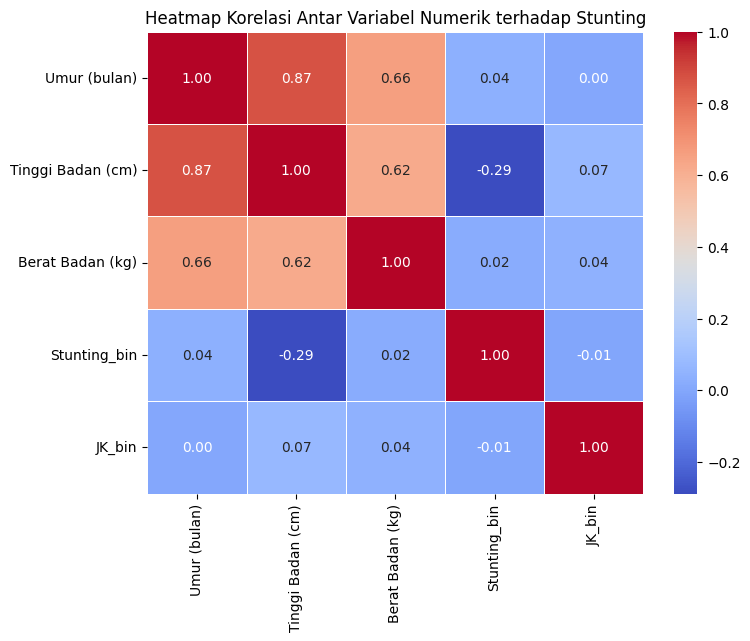

In [13]:
#variasi heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Heatmap Korelasi Antar Variabel Numerik terhadap Stunting", fontsize=12)
plt.show()

In [14]:
# Fitur numerik dan gender
feature_num = ['Umur (bulan)', 'Tinggi Badan (cm)', 'Berat Badan (kg)']
feature_bin = ['JK_bin']

# Gabungkan & drop missing
use_cols = feature_num + feature_bin + ['Stunting_bin']
df_model = df[use_cols].dropna().copy()

X = df_model[feature_num + feature_bin]
y = df_model['Stunting_bin']

print("X shape:", X.shape)
print("Y shape:", y.shape)


X shape: (92692, 4)
Y shape: (92692,)


In [15]:
#Membagi Dataset menjadi Training dan Testing Set
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Data latih:", X_train.shape)
print("Data uji:", X_test.shape)


Data latih: (74153, 4)
Data uji: (18539, 4)


Pembangunan Model Logistic Regression

In [16]:
# Scale hanya fitur numerik, gender langsung passthrough
preprocess = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), feature_num),
        ('bin', 'passthrough', feature_bin),
    ],
    remainder='drop'
)

model = LogisticRegression(
    max_iter=1000,
    solver='lbfgs',
    class_weight='balanced',
    random_state=42
)

clf = Pipeline([
    ('preprocess', preprocess),
    ('model', model)
])

# Latih model
clf.fit(X_train, y_train)
print("✅ Model Logistic Regression berhasil dilatih.")


✅ Model Logistic Regression berhasil dilatih.


Prediksi Model dan Evaluasi Model


In [17]:
# Prediksi & probabilitas
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:, 1]

# Hitung metrik
print(f"Akurasi   : {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision : {precision_score(y_test, y_pred, zero_division=0):.4f}")
print(f"Recall    : {recall_score(y_test, y_pred, zero_division=0):.4f}")
print(f"F1-Score  : {f1_score(y_test, y_pred, zero_division=0):.4f}")
print(f"ROC-AUC   : {roc_auc_score(y_test, y_prob):.4f}")


Akurasi   : 0.9063
Precision : 0.7139
Recall    : 0.9571
F1-Score  : 0.8178
ROC-AUC   : 0.9651


Visualisasi Hasil Evaluasi

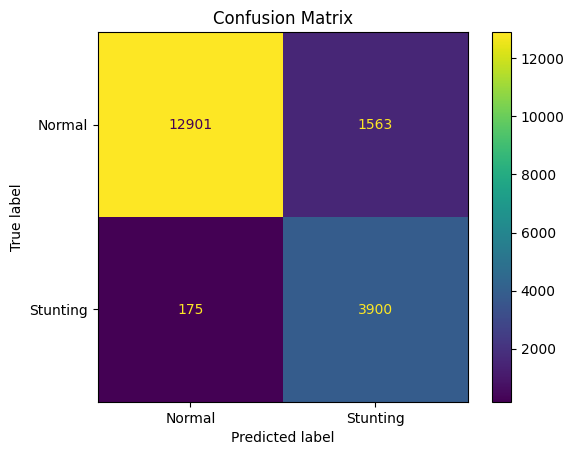

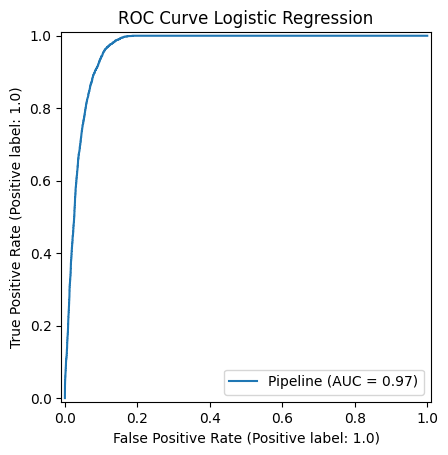

In [18]:
# Confusion Matrix
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred),
                       display_labels=['Normal', 'Stunting']
                      ).plot(values_format='d')
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
RocCurveDisplay.from_estimator(clf, X_test, y_test)
plt.title("ROC Curve Logistic Regression")
plt.show()


Classification Report

In [19]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=['Tidak Stunting(0)', 'Stunting(1)']))

                   precision    recall  f1-score   support

Tidak Stunting(0)       0.99      0.89      0.94     14464
      Stunting(1)       0.71      0.96      0.82      4075

         accuracy                           0.91     18539
        macro avg       0.85      0.92      0.88     18539
     weighted avg       0.93      0.91      0.91     18539



Classification Report

In [20]:
from sklearn.model_selection import cross_val_score

# Lakukan cross validation (cv=5 berarti 5-fold)
scores = cross_val_score(clf, X, y, cv=5)

# Tampilkan hasil
print("Skor tiap fold:", scores)
print("Rata-rata akurasi:", np.mean(scores))
print("Standar deviasi:", np.std(scores))


Skor tiap fold: [0.9084093  0.90414801 0.90468227 0.90673212 0.9028482 ]
Rata-rata akurasi: 0.9053639814725255
Standar deviasi: 0.001970695381359219


Interpretasi Model Logistic Regression


In [21]:
# Ambil nama fitur & koefisien
feat_names = feature_num + feature_bin
coefs = clf.named_steps['model'].coef_[0]
odds = np.exp(coefs)

coef_df = pd.DataFrame({
    'Fitur': feat_names,
    'Koefisien (log-odds)': coefs,
    'Odds Ratio (e^coef)': odds
}).sort_values('Odds Ratio (e^coef)', ascending=False)

display(coef_df)


,Fitur,Koefisien (log-odds),Odds Ratio (e^coef)
0,Umur (bulan),8.661420,5775.733054
3,JK_bin,1.726339,5.620042
2,Berat Badan (kg),0.653153,1.921590
1,Tinggi Badan (cm),-10.742834,0.000022


Prediksi Data Baru (Contoh Kasus)

In [22]:
# Contoh 2 anak
data_baru = pd.DataFrame({
    'Umur (bulan)': [24, 10],
    'Tinggi Badan (cm)': [79.0, 72.5],
    'Berat Badan (kg)': [9.2, 7.8],
    'JK_bin': [1, 0]  # 1 = Laki-laki, 0 = Perempuan
})

pred = clf.predict(data_baru)
prob = clf.predict_proba(data_baru)[:, 1]

hasil = data_baru.copy()
hasil['Prob_Stunting'] = prob
hasil['Pred (0=Tidak,1=Ya)'] = pred
display(hasil)

,Umur (bulan),Tinggi Badan (cm),Berat Badan (kg),JK_bin,Prob_Stunting,"Pred (0=Tidak,1=Ya)"
0,24,79.0,9.2,1,0.998346,1.0
1,10,72.5,7.8,0,0.001810,0.0
